Import the standard stuff

In [578]:
import numpy as np
import matplotlib.pyplot as plt

$ \textbf{Problem 2}$

With the way the assignment questions were phrased, it felt more appropriate to do Problem 2 first and then use my result for Problem 1 as my "integrator".

I started from the recursive function that was designed in class (which I've shamelessly copied below as `integrate_lazy()`), and made some modifications to it to minimize the function calls I make. Particularly, I no longer call the function at points where it has already been evaluated. 

$\textbf{NB: }$ I'm very sorry to do this, and will try to avoid doing this in the future, but you will find another set of handwritten notes in the git repo explaining how the recursive function works and what modifications I made to it. I found it a bit too tedious to typeset the explanation in latex, especially with the diagrams!

I've also included extra comments for this problem only in order to help understand the code in case my notes are not clear enough!

In [579]:
def integrate_lazy(fun,a,b,tol):
    global num_fun_evals_lazy  # to store number of function evaluations
    # print('calling function from ',a,b)
    x=np.linspace(a,b,5)  # divide x interval into 4 subintervals
    dx=x[1]-x[0]  # compute dx
    y=fun(x)  # evaluate function on the interval
    num_fun_evals_lazy += 5  # update evaluation counter
    #do the 3-point integral
    i1=(y[0]+4*y[2]+y[4])/3*(2*dx)
    i2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3*dx
    myerr=np.abs(i1-i2)  # compute error in using 3-point and extended 3-point rule
    if myerr<tol:  
        return i2
    else:
        mid=(a+b)/2  # midpoint of interval
        int1=integrate_lazy(fun,a,mid,tol/2)  # divide interval into two, do the integral on each interval, tol=tol/2
        int2=integrate_lazy(fun,mid,b,tol/2) 
        return int1+int2

def integrate_adaptive(fun,a,b,tol,extra=None):
    global num_fun_evals_norepeats  # to store number of function evaluations
    if np.size(extra)==1:  # first call of the integrator
        
        # print("Running on interval (", a, b, ") \n")
        
        # re-do basically the same thing as prev function
        x=np.linspace(a,b,5) 
        dx=x[1]-x[0]
        y = np.zeros(5)
        
        for i in range(len(x)):
            try:  # catch overflow/divide by zero error
                y[i] = fun(x[i])
            except:
                print("Encountered singularity at z = {}. Setting f(x) to 0.".format(x[i]))
                y[i] = 0
                
        num_fun_evals_norepeats += 5
        #do the 3-point integral
        i1=(y[0]+4*y[2]+y[4])/3*(2*dx)
        i2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3*dx
        myerr=np.abs(i1-i2)
        
        if myerr<tol:
            # print("Done on interval (", a, b, ") \n")
            return i2
        
        else:
            mid=(a+b)/2
            # call integrator recursively on subintervals, modify "extra" with relevant y-values for each interval.
            int1=integrate_adaptive(fun,a,mid,tol/2, extra=np.array([y[0], y[1], y[2]]))
            int2=integrate_adaptive(fun,mid,b,tol/2, extra = np.array([y[2], y[3], y[4]]))
            return int1+int2
        
    else:  # second and higher recursion iteration
        x_new1 = a + (b-a)/4.  # new points to further divide [xi, (xi+xf)/2, xf] into 4 subintervals
        x_new2 = a + 3. * (b-a)/4.
        
        try:  # catch singularities at x_new1
            y_new1 = fun(x_new1)
            
        except:
            print("Encountered singularity at z = {}. Setting f(x) to 0.".format(x_new1))
            print("\n", x_new2)
            y_new1 = 0
            
        try:  # catch singularities at x_new2
            y_new2 = fun(x_new2)
            
        except:
            print("Encountered singularity at z = {}. Setting f(x) to 0.".format(x_new2))
            y_new2 = 0
            
        num_fun_evals_norepeats += 2  # update evaluation counter
        dx = x_new1 - a  # update dx
        
        # create new array (note my convention, which will explain the reordering of indices later)
        # y = [y(xi), y((xi+xf)/2), y(xf), y(x_new1), y(x_new2)]
        y = np.append(extra, [y_new1, y_new2])  
        # do the 3-point integral
        i1=(y[0]+4*y[1]+y[2])/3*(2*dx)
        i2=(y[0]+4*y[3]+2*y[1]+4*y[4]+y[2])/3*dx
        myerr=np.abs(i1-i2)
        if myerr<tol:
            # print("Done on interval (", a, b, ") \n")
            return i2
        else:
            mid=(a+b)/2
            # call integrate_adaptive again but modify "extra" with the correct indices!
            int1=integrate_adaptive(fun,a,mid,tol/2, extra=np.array([y[0], y[3], y[1]]))
            int2=integrate_adaptive(fun,mid,b,tol/2, extra = np.array([y[1], y[4], y[2]]))
            return int1+int2
        

Run a test case with the exponential function

In [580]:
def func(x):
    return np.exp(x)

integral_norepeats = integrate_adaptive(func, 0, 1, 1E-6)
exact_integral = np.exp(1) - 1

print("f(x) = exp(x), x = 0 to 1")
print("Numerical value of integral = ", integral_norepeats)
print("Exact value of integral = ", exact_integral)
print("Numerical error = ", np.abs(exact_integral - integral_norepeats))

f(x) = exp(x), x = 0 to 1
Numerical value of integral =  1.7182818375617717
Exact value of integral =  1.718281828459045
Numerical error =  9.102726572507436e-09


$\textit{Comparison of number of function calls between my new function and the old lazy one from class for a few common functions}$

In [581]:
def func1(x):
    return np.sqrt(x)

def func2(x):
    return np.cos(x)

def func3(x):
    return np.sin(x)/x

def func4(x):
    return np.exp(-x**2)

num_fun_evals_norepeats = 0
num_fun_evals_lazy = 0

integral_norepeats = integrate_adaptive(func1, 0, 10, 1E-6)
integral_lazy = integrate_lazy(func1, 0, 10, 1E-6)
print("f(x) = sqrt(x), x = 0 to 10")
print("Numerical value (no repeat function evals) = ", integral_norepeats)
print("Number of function evaluations = ", num_fun_evals_norepeats)

print("Numerical value (lazy method) = ", integral_lazy)
print("Number of function evaluations = ", num_fun_evals_lazy)

num_fun_evals_norepeats = 0
num_fun_evals_lazy = 0

integral_norepeats = integrate_adaptive(func2, 0, 10, 1E-6)
integral_lazy = integrate_lazy(func2, 0, 10, 1E-6)
print("\n\nf(x) = cos(x), x = 0 to 10")
print("Numerical value (no repeat function evals) = ", integral_norepeats)
print("Number of function evaluations = ", num_fun_evals_norepeats)

print("Numerical value (lazy method) = ", integral_lazy)
print("Number of function evaluations = ", num_fun_evals_lazy)

num_fun_evals_norepeats = 0
num_fun_evals_lazy = 0

integral_norepeats = integrate_adaptive(func3, 1, 10, 1E-6)
integral_lazy = integrate_lazy(func3, 1, 10, 1E-6)
print("\n\nf(x) = sin(x)/x, x = 1 to 10")
print("Numerical value (no repeat function evals) = ", integral_norepeats)
print("Number of function evaluations = ", num_fun_evals_norepeats)

print("Numerical value (lazy method) = ", integral_lazy)
print("Number of function evaluations = ", num_fun_evals_lazy)

num_fun_evals_norepeats = 0
num_fun_evals_lazy = 0

integral_norepeats = integrate_adaptive(func4, -10, 10, 1E-6)
integral_lazy = integrate_lazy(func4, -10, 10, 1E-6)
print("\n\nf(x) = exp(-x^2), x = -10 to 10")
print("Numerical value (no repeat function evals) = ", integral_norepeats)
print("Number of function evaluations = ", num_fun_evals_norepeats)

print("Numerical value (lazy method) = ", integral_lazy)
print("Number of function evaluations = ", num_fun_evals_lazy)

num_fun_evals_norepeats = 0
num_fun_evals_lazy = 0


integral_norepeats = integrate_adaptive(func, -10, 10, 1E-6)
integral_lazy = integrate_lazy(func, -10, 10, 1E-6)
print("\n\nf(x) = exp(x), x = -10 to 10")
print("Numerical value (no repeat function evals) = ", integral_norepeats)
print("Number of function evaluations = ", num_fun_evals_norepeats)

print("Numerical value (lazy method) = ", integral_lazy)
print("Number of function evaluations = ", num_fun_evals_lazy)

f(x) = sqrt(x), x = 0 to 10
Numerical value (no repeat function evals) =  21.08185104384561
Number of function evaluations =  465
Numerical value (lazy method) =  21.08185104384561
Number of function evaluations =  1155


f(x) = cos(x), x = 0 to 10
Numerical value (no repeat function evals) =  -0.5440211120002452
Number of function evaluations =  429
Numerical value (lazy method) =  -0.5440211120002452
Number of function evaluations =  1065


f(x) = sin(x)/x, x = 1 to 10
Numerical value (no repeat function evals) =  0.7122645241978793
Number of function evaluations =  217
Numerical value (lazy method) =  0.7122645241978793
Number of function evaluations =  535


f(x) = exp(-x^2), x = -10 to 10
Numerical value (no repeat function evals) =  1.7724538730261166
Number of function evaluations =  441
Numerical value (lazy method) =  1.7724538730261166
Number of function evaluations =  1095


f(x) = exp(x), x = -10 to 10
Numerical value (no repeat function evals) =  22026.46574942883
Number o

$\textbf{Problem 1}$

Electric Field by a spherical shell. The solution for the electric field at a distance z from the radius is given by:

$E = \frac{R^2 \sigma}{2 \epsilon_0}\int_{-1}^{1} du \bigg[ \frac{z - Ru}{R^2 + z^2 - 2Rzu} \bigg]$

I just got this result from the solution of Griffiths. It is not too difficult to derive but it will be difficult for me to type it out and I'm not sure that the derivation would be of too much use. 

The first goal for this problem is to compute this integral using the integrator I designed above. To this end, I first define a function `dE(z,u)` that computes and returns the integrand in the above expression for a given input `z` and `u`. I then define `z = np.linspace(0.5, 1.5, 100)`, which are all the points at which I would like to know the value of the Electric Field. I also define a couple of zero arrays `E_myintegrator = np.zeros(len(z))` and `E_quad = np.zeros(len(z))` which will store the values of the Electric Field at each `z[i]`.

I then iterate over each `z[i]` and define a (partial) wrapper function using `functools.partial()` that will input `z[i]` as the first argument of `dE(z,u)` and return a new function of `u` that I call `wrapper`, since my integrator is only capable of working with functions of one variable. I then pass this function, the integration limits ($-1,1$) and my tolerance as arguments to my integrator and store the result.

I also call `scipy.integrate.quad()` with the wrapper function and the integration limits as arguments. This function returns the values of the integral as well as a bunch of other information that is not very relevant for this problem. I only store the value of the integral.

I set up a few conditional "modes" to choose if I want to use just quad or just my integrator in the future.

I then plot the results of my integrator as well as quad for all the z-values and also plot the absolute difference between the two methods.

NB - I do include $z < R$ and $z > R$ here but I EXCLUDE z = R here. I will see what happens when I include it in the next section.

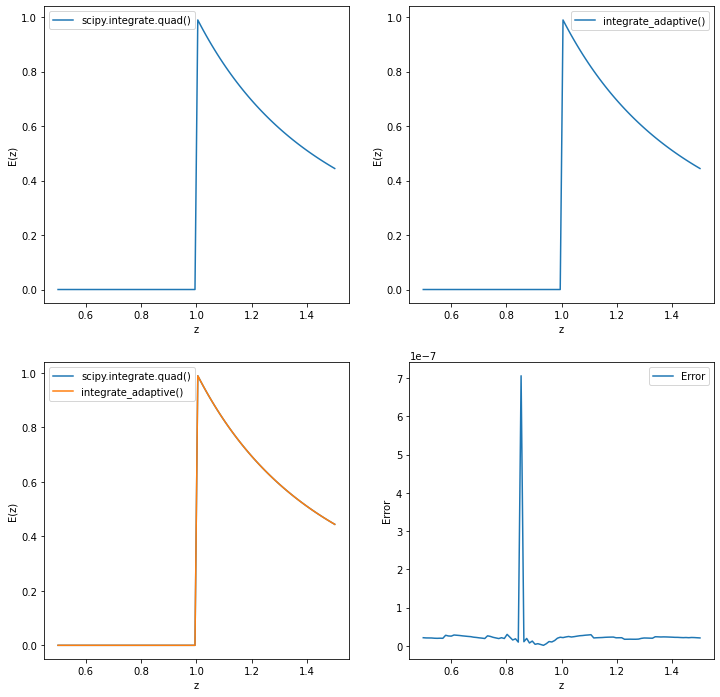

In [582]:
from functools import partial
from scipy import integrate

R = 1.0
sig = 1.0
eps0 = 1.0

def dE(z,u):
    global R, sig, eps0
    return ((R**2 * sig)/(2*eps0)) * ((z - R*u)/(R**2 + z**2 - 2*R*z*u)**(3/2))


z = np.linspace(0.5, 1.5, 100)

def compute_Efield(z, func, mode = 'both'):
    E_myintegrator = np.zeros(len(z))
    E_quad = np.zeros(len(z))

    for i in range(len(z)):
        wrapper = partial(func, z[i])
        if mode == 'both':
            E_myintegrator[i] = integrate_adaptive(wrapper, -1, 1, 1E-6)
            integral, *stuff = integrate.quad(wrapper, -1, 1)
            E_quad[i] = integral
        elif mode == 'quad':
            integral, *stuff = integrate.quad(wrapper, -1, 1)
            E_quad[i] = integral
        elif mode == 'mine':
            E_myintegrator[i] = integrate_adaptive(wrapper, -1, 1, 1E-6)
    return E_myintegrator, E_quad
            
    
def make_plots(z, E1, E2):
    
    if np.max(E2) == np.min(E2):  # check if E2 is all zeros
        plt.rcParams['figure.figsize'] = (6,6)
        plt.plot(z, E1, label = "My integrator")
        plt.title("Electric Field vs z using adaptive dx integrator")
        plt.xlabel("z")
        plt.ylabel("E(z)")
        plt.legend()
        plt.show()
    elif np.max(E1) == np.min(E1):  # check if E1 is all zeros
        plt.rcParams['figure.figsize'] = (6,6)
        plt.plot(z, E2, label = "quad()")
        plt.title("Electric Field vs z using scipy.integrate.quad()")
        plt.xlabel("z")
        plt.ylabel("E(z)")
        plt.legend()
        plt.show()
    else:
        plt.rcParams['figure.figsize'] = (12,12)
        fig, axs = plt.subplots(2,2)
        ax1 = axs[0,0]
        ax2 = axs[0,1]
        ax3 = axs[1,0]
        ax4 = axs[1,1]
        ax1.plot(z,E2, label = "scipy.integrate.quad()")
        ax1.legend()
        ax1.set_xlabel("z")
        ax1.set_ylabel("E(z)")
        ax2.plot(z, E1, label = "integrate_adaptive()")
        ax2.legend()
        ax2.set_xlabel("z")
        ax2.set_ylabel("E(z)")
        ax3.plot(z,E2, label = "scipy.integrate.quad()")
        ax3.plot(z, E1, label = "integrate_adaptive()")
        ax3.legend()
        ax3.set_xlabel("z")
        ax3.set_ylabel("E(z)")
        ax4.plot(z, np.abs(E1 - E2), label = "Error")
        ax4.legend()
        ax4.set_xlabel("z")
        ax4.set_ylabel("Error")
        plt.show()
    

E_myintegrator, E_quad = compute_Efield(z, dE, mode='both')
make_plots(z,E_myintegrator,E_quad)

What happens if I include the point z=R? 
My integrator blows up and my code throws a "divide-by-zero" error. In my integrator, I catch this error and change the corresponding y-value to zero and print an error message.

Encountered singularity at z = 1.0. Setting f(x) to 0.
Encountered singularity at z = 1.0. Setting f(x) to 0.


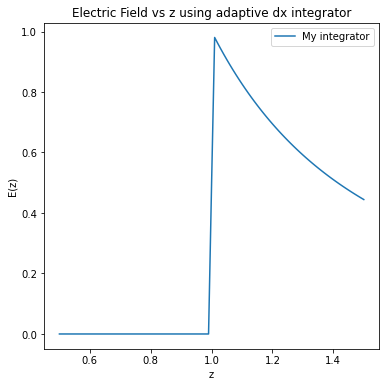

In [583]:
z2 = np.linspace(0.5,1.5,101)
E_myintegrator, E_quad = compute_Efield(z2, dE, mode = 'mine')
make_plots(z2, E_myintegrator, E_quad)

The reason why it throws two error messages is because the region around the singularity needs a mesh that is finer than machine precision to properly resolve, so it eventually double counts z=R. 

Doing the same thing with quad, it works just fine:

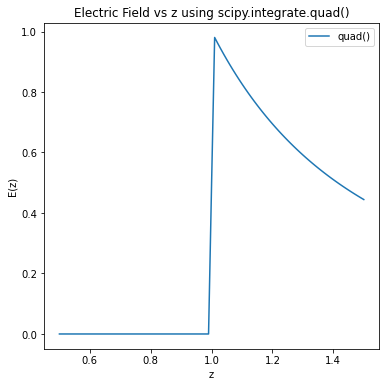

In [584]:
z2 = np.linspace(0.5,1.5,101)
E_myintegrator, E_quad = compute_Efield(z2, dE, mode = 'quad')
make_plots(z2, E_myintegrator, E_quad)

Let's put both together and compare how they do in this case when `z=R=1.0` is included.

Encountered singularity at z = 1.0. Setting f(x) to 0.
Encountered singularity at z = 1.0. Setting f(x) to 0.


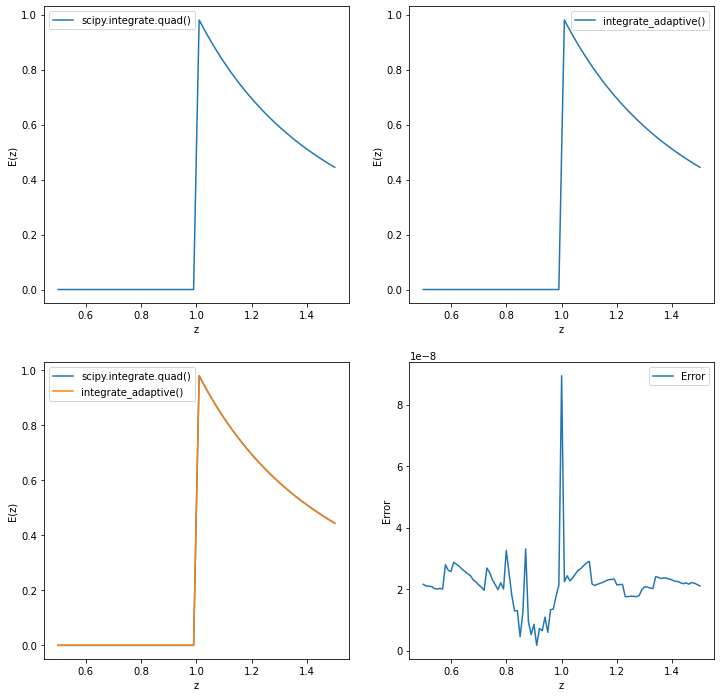

In [585]:
z2 = np.linspace(0.5,1.5,101)
E_myintegrator, E_quad = compute_Efield(z2, dE, mode = 'both')
make_plots(z2, E_myintegrator, E_quad)

Not too bad. There is some disagreement near the singularity, which tells me that `quad()` handles it differently than how I do it. I guess it was to be expected, since all we did was have a point singularity in the integrand. So changing just that value on a fine enough mesh will have no effect on the integral itself.

$\textbf{Problem 3}$

(i) Compute $ \log_2{x}$ for $x \in [0.5,1]$.

I define a function `compute_log2(x, tol)` which takes an array `x` and a tolerance `tol` as input and returns the logarithm to the base two of `x` to within the tolerance.

I first start with a high polynomial degree (25) and a fine x,y (`xuse`, `yuse`) mesh (10001 points). I compute the `log2` of `x` using numpy's `log2` function.

I need to rescale these points so that they lie in $[-1,1]$ instead of $[0.5,1]$. To do so, I define `xp` = 4*`xuse` - 3, which remaps the interval into the one I want, and I put `yxp[i] = func(xuse[i])`, i.e. I assign the values according to the corresponding `xuse`. 

I then do a chebyshev fit on these `x`,`y` points with `degree` = `25`. I then get the an array of the fit coefficients. I then iterate through the array `coeffs` and find the index such that $|$`coeffs[index] + coeffs[index+1] + ...` $|$ is $<$ tolerance. This is because I know the error will be approximately equal to the sum of the absolute values of the coefficients that I choose not to use (this was shown in class, and is verified below). I then use `coeffs[0:index]` as the relevant coefficients to compute the `log2(x)` for any x in the interval. I really only need to do this once, so I can write a separate function that will do this and create a lookup table with the relevant arrays. But the question only asked for 1 function so I included it inside the function. I made it such that no matter how big the input array is, the above computation is only run once. If I need to reuse this code, I will divide it into two functions to help speed it up a bit.

Since I designed my function to work with arrays, it turned out to not work very well if I input just a float. So in this case, I modify my (float) input to a 2-element array by padding it with a `NaN`. I make an empty array `values` that will store the logarithms of all the input x's. I then iterate through each `x[i]` and check if it within $[0.5,1]$. If it is not, I just put `NaN` as the log value and print an error message. Otherwise, I evaluate my Chebyshev fit with the relevant coefficients at `4*x[i]-3` (so that it corresponds to the domain I used for the fit) and store the value. I finally return the array array `values`.

I then compare it to numpy's log2 function on $[0.5,1]$ and make some plots.

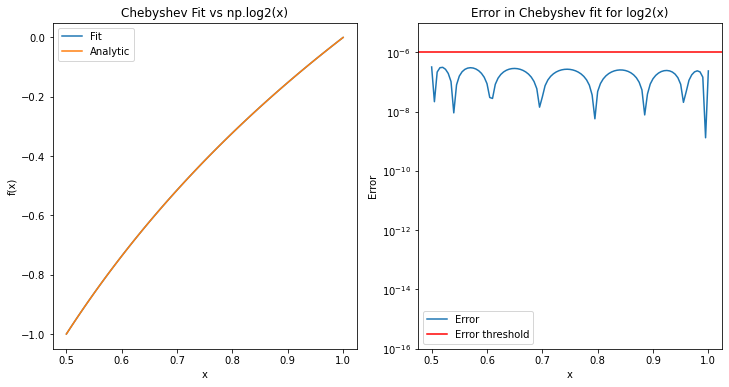

In [586]:
def compute_log2(x, tol):
    degree = 25
    xuse = np.linspace(0.5,1.0,10001)
    xp = 4*xuse-3
    y_xp = np.log2(xuse)

    coeffs = np.polynomial.chebyshev.chebfit(xp, y_xp, degree)
    for i in range(len(coeffs)):
        if np.sum(np.abs(coeffs[i:]))<tol:
            # print("Number of polynomials needed for desired accuracy is: ", 8)
            coeffs = coeffs[:i]
            break
            
    if np.size(x) == 1:
        x = np.append(x, np.nan)
        length = 1
    else:
        length = np.size(x)
    
    values = np.zeros(length)
    
    for i in range(length):
        if x[i]<0.5 or x[i]>1:
            print("x value is out of bounds.")
            values[i] = np.nan
        else:
            values[i] = np.polynomial.chebyshev.chebval(4*x[i]-3, coeffs)

    return values

xx = np.linspace(0.5,1,101)
yy = compute_log2(xx, 1E-6)
yactual = np.log2(xx)

plt.rcParams['figure.figsize'] = (12,6)
fig, axs = plt.subplots(1,2)
ax1 = axs[0]
ax2 = axs[1]
ax2.semilogy(xx, np.abs(yy-yactual), label = "Error")
ax2.axhline(1E-6, label = "Error threshold", c = 'r')
ax2.set_ylim(1E-16,1E-5)
ax2.set_title("Error in Chebyshev fit for log2(x)")
ax2.set_xlabel("x")
ax2.set_ylabel("Error")
ax2.legend()
ax1.plot(xx, yy, label = "Fit")
ax1.plot(xx, yactual, label = "Analytic")
ax1.set_title("Chebyshev Fit vs np.log2(x)")
ax1.set_xlabel("x")
ax1.set_ylabel("f(x)")
ax1.legend()
plt.show()

It turns out I need the first 8 chebyshev polynomials to achieve the desired accuracy over the domain $[0.5,1]$. I have a line in my code that prints it, but I suppressed it so as to not get annoying messages when I run the next part of the problem.

Now I will use the above function to create a function that takes an array `x` of positive numbers and returns the natural log of each number.

The idea is as follows:

$ \ln{(x)} = \ln{(2^{\log_2{(x)}})} = \log_2{(x)} \ln{2}$.

Next we can use the identity: 

$ \ln{(2)} \log_2{(e)} = 1 $
$\implies \ln{(x)} = \frac{\log_2{(x)}}{\log_2{e}}$.

For any number x, we can write it at as $x = a*2^b $ (just as we can write it in scientific notation in powers of 10).
`np.frexp()` does this decomposition and returns `a` (mantissa) and `b` (exponent). It uses the convention that if $x \neq 0$, then the mantissa $\in [0.5,1]$ and mantissa $=0$ iff $x=0$. This is very convenient. So we now have that:

$ \log_2{x} = \log_2{a} + b$. We can compute the first term on the RHS using the function we defined before. We can also put $x=e$ and get $\log_2{e}$ in the same way. We can then take the ratio of the two to get the natural log of x.


I call the function that does precisely this `mylog2(x)`. First it decomposes `np.exp(1)` into its mantissa and exponent and computes `log2(e)` via the procedure outlined above. It then does the same for each `x[i]`. It prints an error message if x is negative or zero. If x is negative, it returns `NaN` and if x is zero is returns `-inf`. It finally takes the ratio of the two logs and returns the natural log as described above.

In [587]:
def mylog2(x):
    e = np.exp(1)
    mantissae, exponente = np.frexp(np.exp(1))
    log2e = compute_log2(mantissae, 1E-6) + exponente
    lognx = np.zeros(len(x))
    mantissa, exponent = np.frexp(x)
    ind0 = np.where(mantissa==0)
    lognx = (compute_log2(mantissa, 1E-6) + exponent ) / log2e
    lognx[ind0] = -np.inf
    return lognx
        

Natural log of the array x is:  [-2.30258536 -0.16841884  0.46373406  0.84801215  1.12492984  1.34155861
  1.51951357  1.67053301  1.80171016  1.91765767  2.02154788  2.11565292
  2.2016596   2.28085081  2.35422838  2.42258819  2.48657237  2.54670729
  2.60343025  2.65710803  2.70805062] 

Standard Deviation compared to numpy.log is:  1.9374994675291286e-07


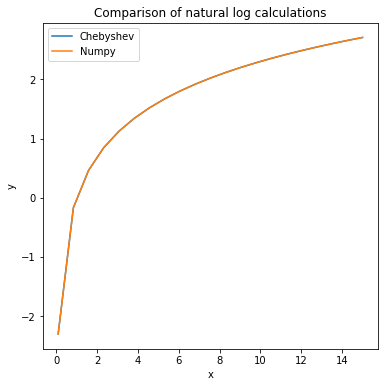

In [588]:
x = np.linspace(0.1, 15, 21)
lognx = mylog2(x)
print("Natural log of the array x is: ", lognx, "\n")
error = np.std(lognx - np.log(x))
print("Standard Deviation compared to numpy.log is: ", error)

plt.rcParams['figure.figsize'] = (6,6)
plt.plot(x, lognx, label = "Chebyshev")
plt.plot(x, np.log(x), label = "Numpy")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparison of natural log calculations")
plt.show()

Try doing this with Legendre polynomials, which are also orthogonal on $[-1,1]$.

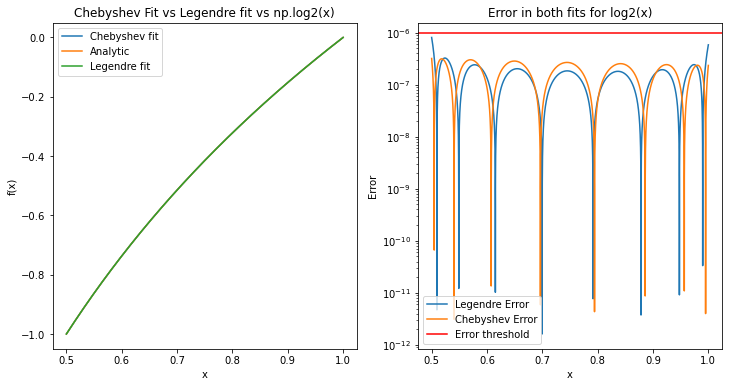

RMS error in Chebyshev fit:  8.504737760667262e-08
Maximum error in Chebyshev fit:  3.1969784974883453e-07
RMS error in Legendre fit:  8.742947841178984e-08
Maximum error in Legendre fit:  8.098970231129599e-07


In [589]:
def legendre_compute_log2(x):
    degree = 7  # we need 8 polynomials here, just as we did for Chebyshev
    xuse = np.linspace(0.5,1.0,10001)
    xp = 4*xuse-3
    y_xp = np.log2(xuse)

    coeffs = np.polynomial.legendre.legfit(xp, y_xp, degree)
    if np.size(x) == 1:
        x = np.append(x, np.nan)
        length = 1
    else:
        length = np.size(x)
    
    values = np.zeros(length)
    
    for i in range(length):
        if x[i]<0.5 or x[i]>1:
            print("x value is out of bounds.")
            values[i] = np.nan
        else:
            values[i] = np.polynomial.legendre.legval(4*x[i]-3, coeffs)

    return values

xx = np.linspace(0.5,1,200001)
yy = compute_log2(xx, 1E-6)
yy_legendre = legendre_compute_log2(xx)
yactual = np.log2(xx)

plt.rcParams['figure.figsize'] = (12,6)
fig, axs = plt.subplots(1,2)
ax1 = axs[0]
ax2 = axs[1]
ax2.semilogy(xx, np.abs(yactual-yy_legendre), label = "Legendre Error")
ax2.semilogy(xx, np.abs(yactual-yy), label = "Chebyshev Error")
ax2.axhline(1E-6, label = "Error threshold", c = 'r')
#ax2.set_ylim(1E-16,1E-5)
ax2.set_title("Error in both fits for log2(x)")
ax2.set_xlabel("x")
ax2.set_ylabel("Error")
ax2.legend()

ax1.plot(xx, yy, label = "Chebyshev fit")
ax1.plot(xx, yactual, label = "Analytic")
ax1.plot(xx, yy_legendre, label = "Legendre fit")
ax1.set_title("Chebyshev Fit vs Legendre fit vs np.log2(x)")
ax1.set_xlabel("x")
ax1.set_ylabel("f(x)")
ax1.legend()
plt.show()

cheb_err = np.abs(yactual - yy)
leg_err = np.abs(yactual - yy_legendre)
print("RMS error in Chebyshev fit: ", np.std(cheb_err))
print("Maximum error in Chebyshev fit: ",np.max(cheb_err))
print("RMS error in Legendre fit: ", np.std(leg_err))
print("Maximum error in Legendre fit: ", np.max(leg_err))

For the same order, the RMS errors are comparable (although Chebyshev is still lower), but the max error of the Legendre fit is almost 2.5x as bad as the Chebyshev fit. Let's now redo the computation for the natural log using Legendre polynomials fit.

In [590]:
def legendre_mylog2(x):
    e = np.exp(1)
    mantissae, exponente = np.frexp(np.exp(1))
    log2e = legendre_compute_log2(mantissae) + exponente
    lognx = np.zeros(len(x))
    mantissa, exponent = np.frexp(x)
    ind0 = np.where(mantissa==0)
    lognx = (legendre_compute_log2(mantissa) + exponent ) / log2e
    lognx[ind0] = -np.inf
    return lognx

Standard Deviation of Chebyshev ln compared to numpy.log is:  1.6736821558077143e-07
Max error of Chebyshev ln compared to numpy.log is:  9.390110520257622e-07
Standard Deviation of Legendre ln compared to numpy.log is:  1.4656206277625204e-07
Max Error of Legendre ln compared to numpy.log is:  1.1752816959642587e-06


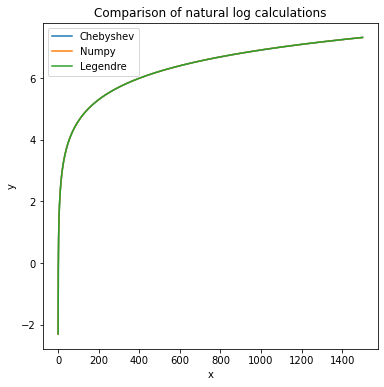

In [593]:
x = np.linspace(0.1, 1500, 200001)
legendre_lognx = legendre_mylog2(x)
lognx = mylog2(x)
cheb_error = np.abs(lognx - np.log(x))
print("Standard Deviation of Chebyshev ln compared to numpy.log is: ", np.std(cheb_error))
print("Max error of Chebyshev ln compared to numpy.log is: ", np.max(cheb_error))

leg_error = np.abs(legendre_lognx - np.log(x))

print("Standard Deviation of Legendre ln compared to numpy.log is: ", np.std(leg_error))
print("Max Error of Legendre ln compared to numpy.log is: ", np.max(leg_error))

plt.rcParams['figure.figsize'] = (6,6)
plt.plot(x, lognx, label = "Chebyshev")
plt.plot(x, np.log(x), label = "Numpy")
plt.plot(x, legendre_lognx, label = "Legendre")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparison of natural log calculations")
plt.show()

Again, we see that the RMS errors are comparable, but the max error for Legendre is significantly worse than Chebyshev. However, it looks like if I make the x-values very large, then the max errors also become quite comparable. For example, if I do, xmax = 1000000:

Standard Deviation of Chebyshev ln compared to numpy.log is:  1.716351434358457e-07
Max error of Chebyshev ln compared to numpy.log is:  1.5928769023787481e-06
Standard Deviation of Legendre ln compared to numpy.log is:  1.4592240507375774e-07
Max Error of Legendre ln compared to numpy.log is:  1.7281593471807355e-06


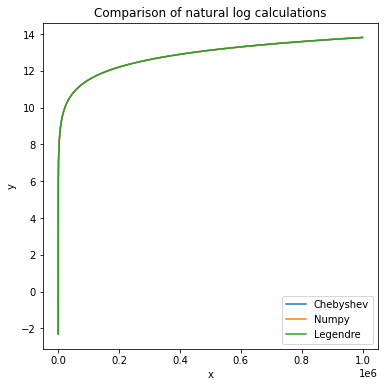

In [595]:
x = np.linspace(0.1, 1000000, 200001)
legendre_lognx = legendre_mylog2(x)
lognx = mylog2(x)
cheb_error = np.abs(lognx - np.log(x))
print("Standard Deviation of Chebyshev ln compared to numpy.log is: ", np.std(cheb_error))
print("Max error of Chebyshev ln compared to numpy.log is: ", np.max(cheb_error))

leg_error = np.abs(legendre_lognx - np.log(x))

print("Standard Deviation of Legendre ln compared to numpy.log is: ", np.std(leg_error))
print("Max Error of Legendre ln compared to numpy.log is: ", np.max(leg_error))

plt.rcParams['figure.figsize'] = (6,6)
plt.plot(x, lognx, label = "Chebyshev")
plt.plot(x, np.log(x), label = "Numpy")
plt.plot(x, legendre_lognx, label = "Legendre")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparison of natural log calculations")
plt.show()

The max errors are also now comparable, which means Chebyshev fits get somewhat worse for very large x. The max error for Chebyshev fit is still lower than Legendre fit though (even though now the RMS error for legendre is lower than for chebyshev).